# ML Group Assignment

## Group 26:
    Minjia Li
    Jay Mahn
    Jiahui Liu
    Lu Zeng

# Missing Values Imputation & Correlation Analysis

In [3]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

## 1.1 CurrentGameMode

In [4]:
train_data = pd.read_csv('data/train_data.csv')

# Fit the model
model = ols('ResponseValue ~ C(CurrentGameMode)', data=train_data).fit()

# Perform ANOVA
anova_results = sm.stats.anova_lm(model, typ=2)  # Type 2 ANOVA DataFrame

# Print the ANOVA table
print(anova_results)

                          sum_sq        df          F        PR(>F)
C(CurrentGameMode)  6.857203e+06       3.0  54.410723  3.889410e-35
Residual            4.931970e+09  117403.0        NaN           NaN


### Interpretation
This indicates that there are significant differences in the ResponseValue across different CurrentGameMode categories, implying that the game mode in which the users are engaged affects their reported well-being scores substantially.

### Suggestion
1)Examine the mean ResponseValue across the different game modes to identify which specific modes are having the most substantial impact.
2)Consider including CurrentGameMode as a key feature in your predictive modeling efforts.

## 1.2 QuestionTiming

Note: This feature has no missing value

In [5]:
from scipy.stats import pointbiserialr

train_data = pd.read_csv('data/train_data.csv')

# Convert 'QuestionTiming' to a binary variable where 'User Initiated' = 1 and 'System Initiated' = 0
train_data['QuestionTiming_binary'] = (train_data['QuestionTiming'] == 'User Initiated').astype(int)

# Calculate point-biserial correlation
correlation, p_value = pointbiserialr(train_data['QuestionTiming_binary'], train_data['ResponseValue'])
print(f"Correlation: {correlation}, P-value: {p_value}")

Correlation: -0.025074037858450724, P-value: 3.773108096097224e-20


### Interpretation
1)Weak Relationship: The correlation between QuestionTiming and ResponseValue is negative but very weak, implying that while there might be a consistent pattern where User Initiated questions are associated with slightly lower wellbeing scores than System Initiated ones, the effect size is minimal. This suggests that while the timing of the question (user vs. system initiated) does influence ResponseValue, it does so very subtly.

2)Statistical Significance: Despite the weak correlation, the relationship is statistically significant. This significance suggests reliability in the observed pattern across the sample data, indicating that the effect, while small, is consistent and repeatable in this dataset.

## 1.3 CurrentSessionLength

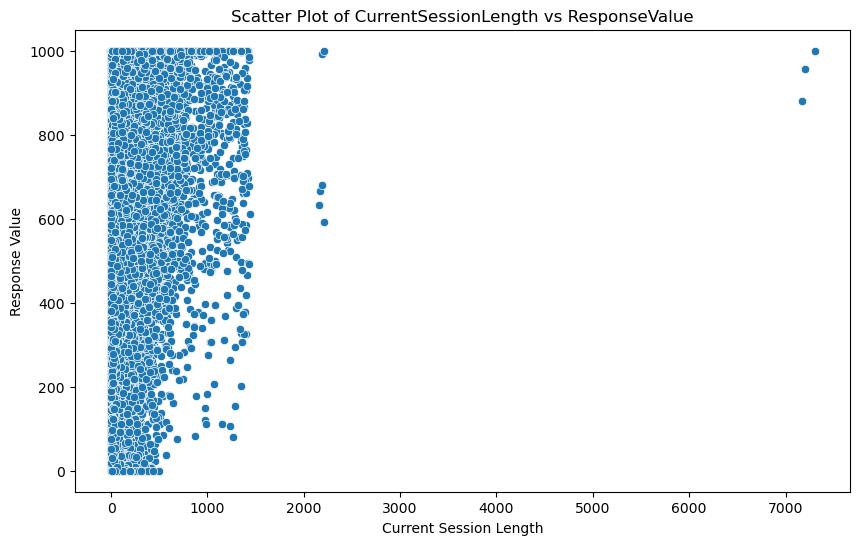

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train_data = pd.read_csv('data/train_data.csv')

# Scatter plot to visualize the relationship
plt.figure(figsize=(10, 6))
sns.scatterplot(x='CurrentSessionLength', y='ResponseValue', data=train_data)
plt.title('Scatter Plot of CurrentSessionLength vs ResponseValue')
plt.xlabel('Current Session Length')
plt.ylabel('Response Value')
plt.show()

In [7]:
correlation = train_data['CurrentSessionLength'].corr(train_data['ResponseValue'])
print(f'Correlation between CurrentSessionLength and ResponseValue: {correlation}')

Correlation between CurrentSessionLength and ResponseValue: 0.060919849473147006


### Interpretation
1) Not statistically significant, might not be very useful when predicting the target values
2) Several outliers

## 1.4 CurrentTask & LastTaskCompleted

### 1.4.1 Target Encoding

In [8]:
#Target encoding
from sklearn.model_selection import KFold

# Define the categorical columns to be encoded
label_cols = ['CurrentTask', 'LastTaskCompleted']
target_col = 'ResponseValue'

# Create a KFold object for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize a DataFrame to store the encoded columns for training data
train_encoded_cols = pd.DataFrame(index=train_data.index)

for col in label_cols:
    train_data[col] = train_data[col].astype(str)
    
    # Initialize a Series to store the target encoding for the training set
    train_encoded = pd.Series(index=train_data.index, dtype=float)
    
    for train_idx, val_idx in kf.split(train_data):
        train_fold, val_fold = train_data.iloc[train_idx], train_data.iloc[val_idx]
        
        # Calculate mean target for each category in the training fold
        category_means = train_fold.groupby(col)[target_col].mean()
        
        # Map the means to the validation fold
        train_encoded[val_idx] = val_fold[col].map(category_means)
    
    # Replace missing values with the overall mean
    train_encoded.fillna(train_data[target_col].mean(), inplace=True)
    train_encoded_cols[col + '_TargetEncoded'] = train_encoded

# Concatenate the target encoded columns to the original training data
train_data = pd.concat([train_data, train_encoded_cols], axis=1)

# Display the first few rows of the processed training data
print("Processed training data:")
print(train_data.head())

# Save the processed data to a new CSV file
train_output_file_path = 'train_data_target_encoded.csv'

train_data.to_csv(train_output_file_path, index=False)

print(f"Processed training data saved to {train_output_file_path}")

Processed training data:
  UserID    QuestionTiming              TimeUtc CurrentGameMode  \
0     p1    User Initiated  2022-08-18 22:55:27             NaN   
1     p1  System Initiated  2022-08-18 23:38:31             NaN   
2     p1    User Initiated  2022-08-18 23:39:24          Career   
3     p1  System Initiated  2022-08-18 23:45:01          Career   
4     p1  System Initiated  2022-08-18 23:51:22          Career   

                 CurrentTask  CurrentSessionLength LastTaskCompleted  \
0                        nan                     2               nan   
1                        nan                     0               nan   
2                   HOME_VAN                     1        WASH_PWVan   
3  RESIDENTIALSMALL_BACKYARD                     6        WASH_PWVan   
4  RESIDENTIALSMALL_BACKYARD                    13        WASH_PWVan   

   LevelProgressionAmount QuestionType  ResponseValue  \
0                     NaN    Wellbeing          509.0   
1                     NaN

### 1.4.2 Missing Values Imputation Using KNN

In [9]:
from sklearn.impute import KNNImputer

train_data = pd.read_csv('train_data_target_encoded.csv')

# Select the two features 'CurrentTask_TargetEncoded' and 'LastTaskCompleted_TargetEncoded'
features_to_impute = ['CurrentTask_TargetEncoded', 'LastTaskCompleted_TargetEncoded']

# Initialize KNN imputer
imputer = KNNImputer(n_neighbors=5)

# Impute the missing values
imputed_data = imputer.fit_transform(train_data[features_to_impute])

# Transfer the filled data back to the DataFrame
imputed_df = pd.DataFrame(imputed_data, columns=features_to_impute, index=train_data.index)

# Re-assign the filled features back to the original dataset
train_data[features_to_impute] = imputed_df[features_to_impute]

print("Processed training data with imputed values:")
print(train_data.head())

# Save the imputed data to a new csv file
train_output_file_path = 'train_data_knn_imputed.csv'
train_data.to_csv(train_output_file_path, index=False)


Processed training data with imputed values:
  UserID    QuestionTiming              TimeUtc CurrentGameMode  \
0     p1    User Initiated  2022-08-18 22:55:27             NaN   
1     p1  System Initiated  2022-08-18 23:38:31             NaN   
2     p1    User Initiated  2022-08-18 23:39:24          Career   
3     p1  System Initiated  2022-08-18 23:45:01          Career   
4     p1  System Initiated  2022-08-18 23:51:22          Career   

                 CurrentTask  CurrentSessionLength LastTaskCompleted  \
0                        NaN                     2               NaN   
1                        NaN                     0               NaN   
2                   HOME_VAN                     1        WASH_PWVan   
3  RESIDENTIALSMALL_BACKYARD                     6        WASH_PWVan   
4  RESIDENTIALSMALL_BACKYARD                    13        WASH_PWVan   

   LevelProgressionAmount QuestionType  ResponseValue  \
0                     NaN    Wellbeing          509.0   
1    

### 1.4.3 Explore the correlation after imputing

In [10]:
train_data = pd.read_csv('train_data_knn_imputed.csv')

# Calculate the correlation of 'CurrentTask_TargetEncoded' and 'LastTaskCompleted_TargetEncoded' respectively
corr_current_task = train_data['CurrentTask_TargetEncoded'].corr(train_data['ResponseValue'])
corr_last_task_completed = train_data['LastTaskCompleted_TargetEncoded'].corr(train_data['ResponseValue'])

print(f'Correlation between CurrentTask_TargetEncoded and ResponseValue: {corr_current_task}')
print(f'Correlation between LastTaskCompleted_TargetEncoded and ResponseValue: {corr_last_task_completed}')

Correlation between CurrentTask_TargetEncoded and ResponseValue: 0.14480936382934512
Correlation between LastTaskCompleted_TargetEncoded and ResponseValue: 0.08626353155595749


In [11]:
# Create an interaction term and calculate correlation between the interaction term and 'ResponseValue'

# Create the interaction term
train_data['Interaction_Term'] = train_data['CurrentTask_TargetEncoded'] * train_data['LastTaskCompleted_TargetEncoded']

# Calculate the correlation
corr_interaction_term = train_data['Interaction_Term'].corr(train_data['ResponseValue'])

print(f'Correlation between Interaction Term and ResponseValue: {corr_interaction_term}')

Correlation between Interaction Term and ResponseValue: 0.14549276563151312


In [12]:
# Analyse using OLS
formula = 'ResponseValue ~ CurrentTask_TargetEncoded + LastTaskCompleted_TargetEncoded + Interaction_Term'

model = ols(formula, data=train_data).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:          ResponseValue   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     1032.
Date:                Wed, 22 May 2024   Prob (F-statistic):               0.00
Time:                        16:40:52   Log-Likelihood:            -9.0975e+05
No. Observations:              134420   AIC:                         1.820e+06
Df Residuals:                  134416   BIC:                         1.820e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

### Interpretation

1) All Correlation above (including the two feature individually and their interaction term) close to 0, indicating a positive but weak correlation.

## 1.5 CurrentGameMode Imputation

In [13]:
from sklearn.preprocessing import LabelEncoder

# load the data
train_data = pd.read_csv('train_data_knn_imputed.csv')
print(train_data['CurrentGameMode'].unique())

# Initialize LabelEncoder
le = LabelEncoder()

# Encoding 'CurrentGameMode' using Label Encoding
train_data['CurrentGameMode_LabelEncoded'] = le.fit_transform(train_data['CurrentGameMode'])

train_data.head()


[nan 'Career' 'Special' 'FreePlay' 'Challenge']


,UserID,QuestionTiming,TimeUtc,CurrentGameMode,CurrentTask,CurrentSessionLength,LastTaskCompleted,LevelProgressionAmount,QuestionType,ResponseValue,CurrentTask_TargetEncoded,LastTaskCompleted_TargetEncoded,CurrentGameMode_LabelEncoded
0,p1,User Initiated,2022-08-18 22:55:27,NaN,NaN,2,NaN,NaN,Wellbeing,509.0,678.088886,739.659622,4
1,p1,System Initiated,2022-08-18 23:38:31,NaN,NaN,0,NaN,NaN,Wellbeing,653.0,679.424995,739.581741,4
2,p1,User Initiated,2022-08-18 23:39:24,Career,HOME_VAN,1,WASH_PWVan,1.000000,Wellbeing,705.0,748.526316,769.702957,0
3,p1,System Initiated,2022-08-18 23:45:01,Career,RESIDENTIALSMALL_BACKYARD,6,WASH_PWVan,0.168267,Wellbeing,817.0,766.964641,770.748832,0
4,p1,System Initiated,2022-08-18 23:51:22,Career,RESIDENTIALSMALL_BACKYARD,13,WASH_PWVan,0.429364,Wellbeing,810.0,764.407770,768.810243,0


In [14]:
# Initialize KNN Imputer
imputer = KNNImputer(n_neighbors=5)

# Select feature 'CurrentGameMode_LabelEncoded' to be imputed
features_to_impute = ['CurrentGameMode_LabelEncoded', 'CurrentTask_TargetEncoded']

# Impute the missing values
imputed_data = imputer.fit_transform(train_data[features_to_impute])

# Transfer the filled data back to the DataFrame
imputed_df = pd.DataFrame(imputed_data, columns=features_to_impute, index=train_data.index)

# Re-new the original 'CurrentGameMode_LabelEncoded' data 
train_data['CurrentGameMode_LabelEncoded'] = imputed_df['CurrentGameMode_LabelEncoded']

print("Processed training data with imputed CurrentGameMode:")
print(train_data.head())

# Save and renew the file
train_output_file_path = 'train_data_knn_imputed.csv'
train_data.to_csv(train_output_file_path, index=False)

Processed training data with imputed CurrentGameMode:
  UserID    QuestionTiming              TimeUtc CurrentGameMode  \
0     p1    User Initiated  2022-08-18 22:55:27             NaN   
1     p1  System Initiated  2022-08-18 23:38:31             NaN   
2     p1    User Initiated  2022-08-18 23:39:24          Career   
3     p1  System Initiated  2022-08-18 23:45:01          Career   
4     p1  System Initiated  2022-08-18 23:51:22          Career   

                 CurrentTask  CurrentSessionLength LastTaskCompleted  \
0                        NaN                     2               NaN   
1                        NaN                     0               NaN   
2                   HOME_VAN                     1        WASH_PWVan   
3  RESIDENTIALSMALL_BACKYARD                     6        WASH_PWVan   
4  RESIDENTIALSMALL_BACKYARD                    13        WASH_PWVan   

   LevelProgressionAmount QuestionType  ResponseValue  \
0                     NaN    Wellbeing          509.0

## 1.6 LevelProgressionAmount

Text(0, 0.5, 'ResponseValue')

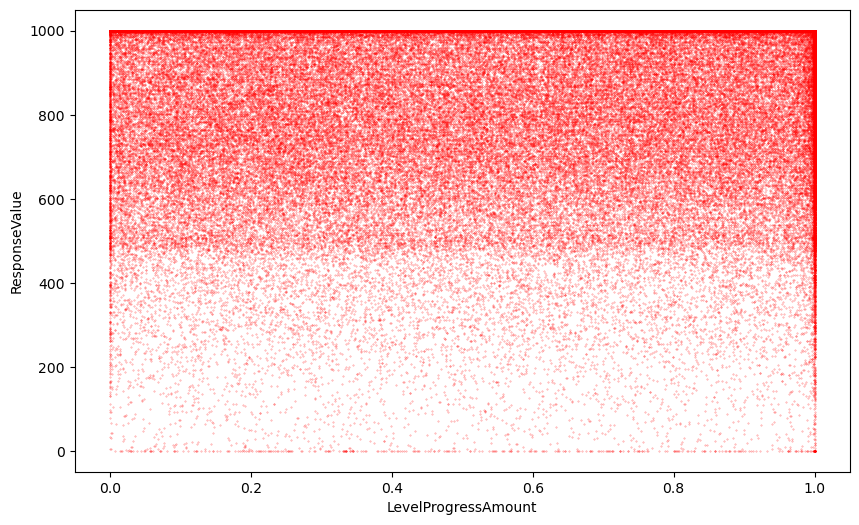

In [15]:
plt.figure(figsize=(10, 6))
plt.scatter(train_data['LevelProgressionAmount'], train_data['ResponseValue'], s = 0.1, c='red', alpha=0.5)
plt.xlabel('LevelProgressAmount')
plt.ylabel('ResponseValue')

In [16]:
# Calculate the correlation
correlation = train_data['LevelProgressionAmount'].corr(train_data['ResponseValue'])
print(f'Correlation between LevelProgressionAmount and ResponseValue: {correlation}')

Correlation between LevelProgressionAmount and ResponseValue: 0.023279352821100625


In [17]:
# Mean Imputation
train_data['LevelProgressionAmount'].fillna(train_data['LevelProgressionAmount'].mean(), inplace=True)

# Calculate the correlation
correlation = train_data['LevelProgressionAmount'].corr(train_data['ResponseValue'])
print(f'Correlation between LevelProgressionAmount and ResponseValue: {correlation}')

Correlation between LevelProgressionAmount and ResponseValue: 0.02096646374853591


In [18]:
# Median Imputation
train_data['LevelProgressionAmount'].fillna(train_data['LevelProgressionAmount'].median(), inplace=True)

# Calculate the correlation
correlation = train_data['LevelProgressionAmount'].corr(train_data['ResponseValue'])
print(f'Correlation between LevelProgressionAmount and ResponseValue: {correlation}')

Correlation between LevelProgressionAmount and ResponseValue: 0.02096646374853591


### Interpretation

1) Have tried correlation with missing values / with mean imputation / with median imputation, all shows a weak correlation

## 1.7 TimeUtc

In [19]:
train_data = pd.read_csv("train_data_knn_imputed.csv")

# Ensure TimeUtc is a datetime type
train_data['TimeUtc'] = pd.to_datetime(train_data['TimeUtc'])

# Extract components
train_data['Year'] = train_data['TimeUtc'].dt.year
train_data['Month'] = train_data['TimeUtc'].dt.month
train_data['Day'] = train_data['TimeUtc'].dt.day
train_data['Hour'] = train_data['TimeUtc'].dt.hour
train_data['Minute'] = train_data['TimeUtc'].dt.minute
train_data['Second'] = train_data['TimeUtc'].dt.second

# Separate weekday and weekend days
train_data['Weekday'] = train_data['TimeUtc'].dt.dayofweek
train_data['WeekendFlag'] = (train_data['TimeUtc'].dt.weekday >= 5).astype(int)

# Categorize different times of day into periods
time_bins = [0, 6, 12, 18, 24]  # Define time_bins as 0-6, 6-12, 12-18, 18-24
time_labels = ['Night', 'Morning', 'Afternoon', 'Evening']
train_data['PeriodOfDay'] = pd.cut(train_data['TimeUtc'].dt.hour, bins=time_bins, labels=time_labels, right=False)

# Remove the original Timestamp column to avoid redundancy
train_data.drop('TimeUtc', axis=1, inplace=True)

train_data.head()

,UserID,QuestionTiming,CurrentGameMode,CurrentTask,CurrentSessionLength,LastTaskCompleted,LevelProgressionAmount,QuestionType,ResponseValue,CurrentTask_TargetEncoded,...,CurrentGameMode_LabelEncoded,Year,Month,Day,Hour,Minute,Second,Weekday,WeekendFlag,PeriodOfDay
0,p1,User Initiated,NaN,NaN,2,NaN,NaN,Wellbeing,509.0,678.088886,...,4.0,2022,8,18,22,55,27,3,0,Evening
1,p1,System Initiated,NaN,NaN,0,NaN,NaN,Wellbeing,653.0,679.424995,...,4.0,2022,8,18,23,38,31,3,0,Evening
2,p1,User Initiated,Career,HOME_VAN,1,WASH_PWVan,1.000000,Wellbeing,705.0,748.526316,...,0.0,2022,8,18,23,39,24,3,0,Evening
3,p1,System Initiated,Career,RESIDENTIALSMALL_BACKYARD,6,WASH_PWVan,0.168267,Wellbeing,817.0,766.964641,...,0.0,2022,8,18,23,45,1,3,0,Evening
4,p1,System Initiated,Career,RESIDENTIALSMALL_BACKYARD,13,WASH_PWVan,0.429364,Wellbeing,810.0,764.407770,...,0.0,2022,8,18,23,51,22,3,0,Evening


In [20]:
#encoding for TimeOfDay.
train_data = pd.get_dummies(train_data, columns=['PeriodOfDay'], drop_first=False)

train_data.head()

,UserID,QuestionTiming,CurrentGameMode,CurrentTask,CurrentSessionLength,LastTaskCompleted,LevelProgressionAmount,QuestionType,ResponseValue,CurrentTask_TargetEncoded,...,Day,Hour,Minute,Second,Weekday,WeekendFlag,PeriodOfDay_Night,PeriodOfDay_Morning,PeriodOfDay_Afternoon,PeriodOfDay_Evening
0,p1,User Initiated,NaN,NaN,2,NaN,NaN,Wellbeing,509.0,678.088886,...,18,22,55,27,3,0,False,False,False,True
1,p1,System Initiated,NaN,NaN,0,NaN,NaN,Wellbeing,653.0,679.424995,...,18,23,38,31,3,0,False,False,False,True
2,p1,User Initiated,Career,HOME_VAN,1,WASH_PWVan,1.000000,Wellbeing,705.0,748.526316,...,18,23,39,24,3,0,False,False,False,True
3,p1,System Initiated,Career,RESIDENTIALSMALL_BACKYARD,6,WASH_PWVan,0.168267,Wellbeing,817.0,766.964641,...,18,23,45,1,3,0,False,False,False,True
4,p1,System Initiated,Career,RESIDENTIALSMALL_BACKYARD,13,WASH_PWVan,0.429364,Wellbeing,810.0,764.407770,...,18,23,51,22,3,0,False,False,False,True


### 1.7.1 Weekday

In [21]:
weekday_unique_values = train_data['Weekday'].unique()
print(weekday_unique_values)

from scipy.stats import f_oneway

grouped_data = [train_data[train_data['Weekday'] == i]['ResponseValue'] for i in range(7)]

f_stat, p_val = f_oneway(*grouped_data)
print('F-statistic:', f_stat)
print('P-value:', p_val)

[3 4 5 6 0 2 1]
F-statistic: 9.982346547601745
P-value: 4.757252476160118e-11


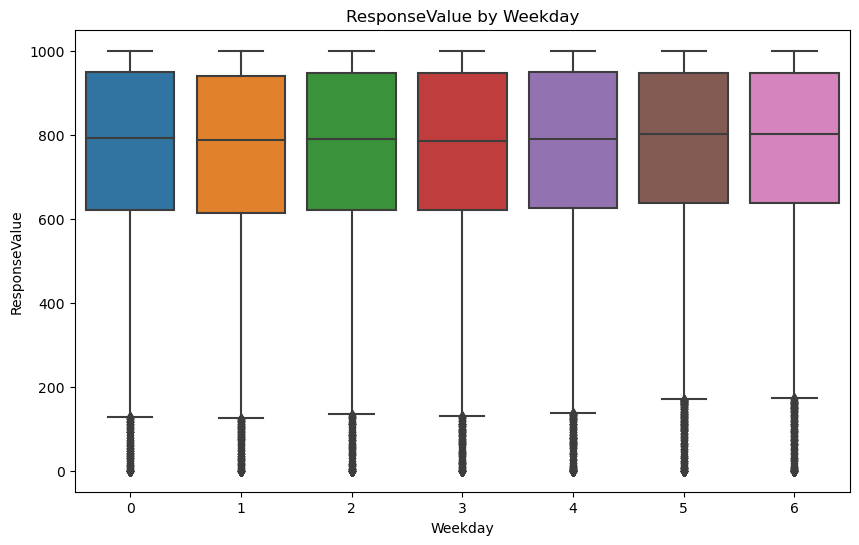

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x='Weekday', y='ResponseValue', data=train_data)
plt.title('ResponseValue by Weekday')
plt.xlabel('Weekday')
plt.ylabel('ResponseValue')
plt.show()

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     0      1  -4.5432 0.4142 -11.2391  2.1527  False
     0      2  -0.6859 0.9999   -7.377  6.0052  False
     0      3  -3.1834 0.7864  -9.7533  3.3864  False
     0      4   0.2729    1.0  -6.0571  6.6029  False
     0      5   6.4562 0.0382   0.1944  12.718   True
     0      6   8.4067 0.0017   2.0817 14.7317   True
     1      2   3.8573 0.6415  -2.9846 10.6992  False
     1      3   1.3598 0.9969  -5.3636  8.0832  False
     1      4   4.8161 0.3018  -1.6731 11.3053  False
     1      5  10.9994    0.0   4.5767 17.4221   True
     1      6  12.9499    0.0   6.4655 19.4343   True
     2      3  -2.4975 0.9295  -9.2161  4.2211  False
     2      4   0.9588 0.9995  -5.5255  7.4431  False
     2      5   7.1421 0.0179   0.7243 13.5598   True
     2      6   9.0926 0.0007   2.6132 15.5721   True
     3      4   3.4563 0.680

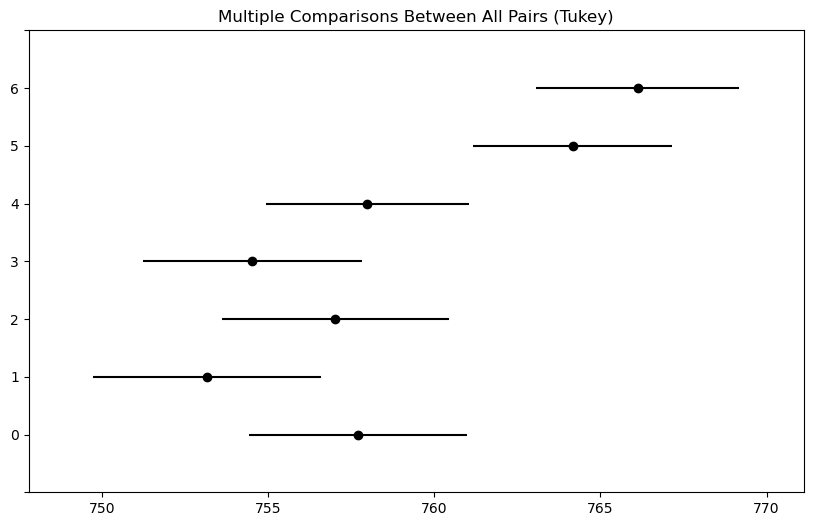

In [23]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=train_data['ResponseValue'], groups=train_data['Weekday'], alpha=0.05)
print(tukey)

tukey.plot_simultaneous()
plt.show()

#### Interpretation
Significant difference: There is a significant difference in ResponseValue between specific Weekday groups. In particular, the ResponseValue is significantly different on Sunday (Group 6) compared to other days (0, 1, 2, 3, 4, 5).
The effect of Sunday is obvious: The significant difference between Sunday (Group 6) and other days shows that the ResponseValue of Sunday is significantly higher than that of other days.

### 1.7.2 Weekend

[0 1]
Point-Biserial Correlation: 0.019626286413512523, P-value: 6.187889079493329e-13
Mean on Weekdays: 756.1773873369965, Mean on Weekends: 765.1190305497098
T-statistic: -7.196983488263627, P-value: 6.187889079510141e-13


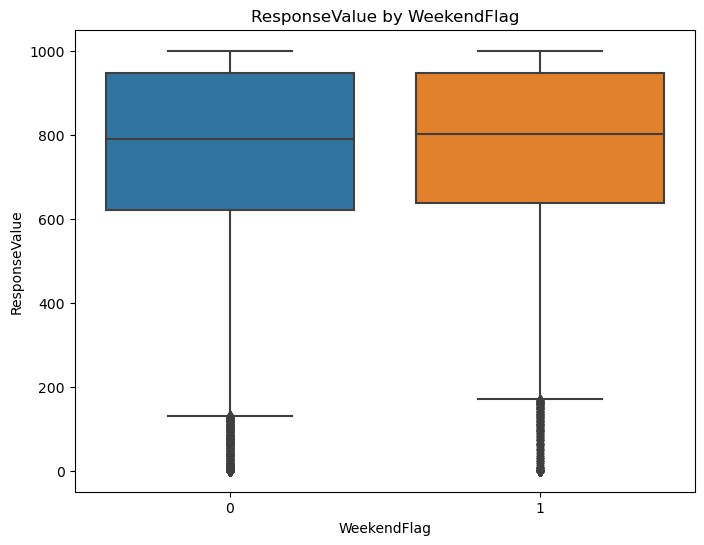

In [24]:
from scipy.stats import pointbiserialr, ttest_ind

WeekendFlag_unique_values = train_data['WeekendFlag'].unique()
print(WeekendFlag_unique_values)

correlation, p_value = pointbiserialr(train_data['WeekendFlag'], train_data['ResponseValue'])
print(f"Point-Biserial Correlation: {correlation}, P-value: {p_value}")

mean_weekday = train_data[train_data['WeekendFlag'] == 0]['ResponseValue'].mean()
mean_weekend = train_data[train_data['WeekendFlag'] == 1]['ResponseValue'].mean()
print(f"Mean on Weekdays: {mean_weekday}, Mean on Weekends: {mean_weekend}")

group_weekday = train_data[train_data['WeekendFlag'] == 0]['ResponseValue']
group_weekend = train_data[train_data['WeekendFlag'] == 1]['ResponseValue']
t_stat, p_val = ttest_ind(group_weekday, group_weekend)
print(f"T-statistic: {t_stat}, P-value: {p_val}")

plt.figure(figsize=(8, 6))
sns.boxplot(x='WeekendFlag', y='ResponseValue', data=train_data)
plt.title('ResponseValue by WeekendFlag')
plt.xlabel('WeekendFlag')
plt.ylabel('ResponseValue')
plt.show()

#### Interpretation
Although the linear correlation between WeekendFlag and ResponseValue is very weak, mean comparison and t-test found that there is a significant difference in ResponseValue between weekdays and weekends, and this difference is statistically significant.

### 1.7.3 PeriodOfDay

In [25]:
import statsmodels.formula.api as smf

formula = 'ResponseValue ~ PeriodOfDay_Afternoon + PeriodOfDay_Evening + PeriodOfDay_Night'

model = smf.ols(formula, data=train_data).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          ResponseValue   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     14.86
Date:                Wed, 22 May 2024   Prob (F-statistic):           1.13e-09
Time:                        16:40:55   Log-Likelihood:            -9.1126e+05
No. Observations:              134420   AIC:                         1.823e+06
Df Residuals:                  134416   BIC:                         1.823e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

#### Interpretation
PeriodOfDay_Afternoon has a significant negative impact on ResponseValue. 
Compared with Morning, the ResponseValue of Afternoon period is about 4.3 lower on average.

PeriodOfDay_Evening has no significant impact on ResponseValue. 
Compared with Morning, the ResponseValue of Evening period does not change significantly.

PeriodOfDay_Night has a significant positive impact on ResponseValue. 
Compared to Morning, the ResponseValue in Night period increases by about 5.8 on average.

In [26]:
# Save the transformation and encoding for 'TimeUtc' to the 'train_data_knn_imputed.csv' 
train_output_file_path = 'train_data_knn_imputed.csv'
train_data.to_csv(train_output_file_path, index=False)

## 1.8 Note!!

1. All the imputation operations now will be gathered into a new csv file 'train_data_knn_imputed.csv', which will be saved on your working directory, you can use this csv file for your model building

## 1.9 Summary

### 1.9.1 Feature Encoding

1. QuestionTiming: Dummy Encoded
2. TimeUtc: Deconstruct (see train_data_knn_imputed.csv)
3. CurrentGameMode: Label Encoded
4. CurrentTask: Target Encoded
5. LaskTaskCompleted: Target Encoded


### 1.9.2 Missing Values Imputation

1. UserID: No missing value
2. QuestionTiming: No missing value
3. TimeUtc: No missing value
4. CurrentGameMode: KNN
5. CurrentTask: KNN
6. CurrentSessionLength: No missing value
7. LastTaskCompleted: KNN
8. LevelProressionAmount: No missing value
9. QuestionType: No missing value

### 1.9.3 Correlation Analysis

#### 1.9.3.1 QuestionTiming

1. Weak Relationship: The correlation between QuestionTiming and ResponseValue is negative but very weak, implying that while there might be a consistent pattern where User Initiated questions are associated with slightly lower wellbeing scores than System Initiated ones, the effect size is minimal. This suggests that while the timing of the question (user vs. system initiated) does influence ResponseValue, it does so very subtly.

2. Statistical Significance: Despite the weak correlation, the relationship is statistically significant. This significance suggests reliability in the observed pattern across the sample data, indicating that the effect, while small, is consistent and repeatable in this dataset.

#### 1.9.3.2 CurrentGameMode

Significant correlation relationship: There are significant differences in the ResponseValue across different CurrentGameMode categories, implying that the game mode in which the users are engaged affects their reported well-being scores substantially.

#### 1.9.3.3 CurrentTask & LastTaskCompleted

1. CurrentTask: Weak positive correlation
2. LastTaskCompleted: Weak positive correlation
3. Interaction term: Weak positive correlation

#### 1.9.3.4 CurrentSessionLength

Weak positive correlation, not statistically significant

#### 1.9.3.5 LevelProgressionAmount

Weak positive correlation, not statistically significant

#### 1.9.3.6 TimeUtc

1. Significant difference: There is a significant difference in ResponseValue between specific Weekday groups. In particular, the ResponseValue is significantly different on Sunday (Group 6) compared to other days (0, 1, 2, 3, 4, 5). The effect of Sunday is obvious: The significant difference between Sunday (Group 6) and other days shows that the ResponseValue of Sunday is significantly higher than that of other days.

2. Although the linear correlation between WeekendFlag and ResponseValue is very weak, mean comparison and t-test found that there is a significant difference in ResponseValue between weekdays and weekends, and this difference is statistically significant.

3. PeriodOfDay_Afternoon has a significant negative impact on ResponseValue. Compared with Morning, the ResponseValue of Afternoon period is about 4.3 lower on average.

4. PeriodOfDay_Evening has no significant impact on ResponseValue. Compared with Morning, the ResponseValue of Evening period does not change significantly.

5. PeriodOfDay_Night has a significant positive impact on ResponseValue. Compared to Morning, the ResponseValue in Night period increases by about 5.8 on average.

## Supplement

#### LevelProgressionAmount-KNN

In [27]:
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Read the CSV file
file_path = 'train_data_knn_imputed.csv'
df = pd.read_csv(file_path)

# Select the column to encode and impute
column_to_encode_and_impute = 'LevelProgressionAmount'

# Encode the column
label_encoder = LabelEncoder()
df[column_to_encode_and_impute] = label_encoder.fit_transform(df[column_to_encode_and_impute].astype(str))

# Create KNNImputer instance
imputer = KNNImputer(n_neighbors=5)

# Perform KNN imputation on the selected column
df[[column_to_encode_and_impute]] = imputer.fit_transform(df[[column_to_encode_and_impute]])

# Standardize the imputed column
scaler = StandardScaler()
df[[column_to_encode_and_impute]] = scaler.fit_transform(df[[column_to_encode_and_impute]])

# Save the modified data back to the original file
df.to_csv(file_path, index=False)

print(f'Successfully encoded and performed KNN imputation on {column_to_encode_and_impute}. The result has been saved back to the original file {file_path}')


Successfully encoded and performed KNN imputation on LevelProgressionAmount. The result has been saved back to the original file train_data_knn_imputed.csv


#### QuestionTiming-Dummy

In [28]:
import pandas as pd

file_path = 'train_data_knn_imputed.csv'
df = pd.read_csv(file_path)

df_encoded = pd.get_dummies(df, columns=['QuestionTiming'])

df_encoded.to_csv(file_path, index=False)

print(f'{file_path}')


train_data_knn_imputed.csv


#### Drop useless features

In [29]:
import pandas as pd


file_path = 'train_data_knn_imputed.csv' 
df = pd.read_csv(file_path)

columns_to_delete = ['UserID', 'Minute','Second','QuestionType','LastTaskCompleted','CurrentGameMode','CurrentTask']  # 替换为你想删除的列名

df = df.drop(columns=columns_to_delete)

new_file_path = 'new_train_data_knn_imputed.csv'  
df.to_csv(new_file_path, index=False)

print(f'successfully drop {new_file_path}')

successfully drop new_train_data_knn_imputed.csv


#### Scale the features

In [63]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

file_path = 'new_train_data_knn_imputed.csv'  
data = pd.read_csv(file_path)

columns_to_scale = ['CurrentSessionLength', 'LevelProgressionAmount',
                    'CurrentTask_TargetEncoded', 'LastTaskCompleted_TargetEncoded']

scaler = StandardScaler()

data_scaled = data.copy()
data_scaled[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

scaled_file_path = 'scaled_new_train_data_knn_imputed.csv'  
data_scaled.to_csv(scaled_file_path, index=False)

print(f"Standardized data saved to {scaled_file_path}")


Standardized data saved to scaled_new_train_data_knn_imputed.csv


#### Lasso

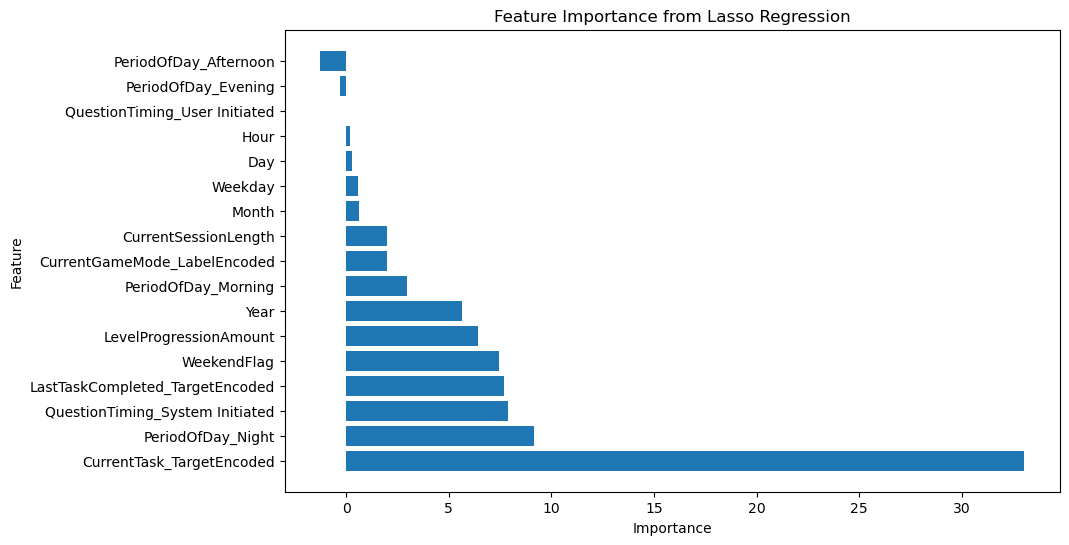

In [64]:
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

file_path = 'scaled_new_train_data_knn_imputed.csv'  
final_data = pd.read_csv(file_path)

target = 'ResponseValue'
features = final_data.drop(columns=[target])
target_data = final_data[target]

X_train, X_test, y_train, y_test = train_test_split(features, target_data, test_size=0.2, random_state=42)

lasso = Lasso(alpha=0.001)  
lasso.fit(X_train, y_train)

coefficients = lasso.coef_

feature_importance = pd.DataFrame({'Feature': features.columns, 'Importance': coefficients})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Lasso Regression')
plt.show()


#### XGBoost

In [50]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


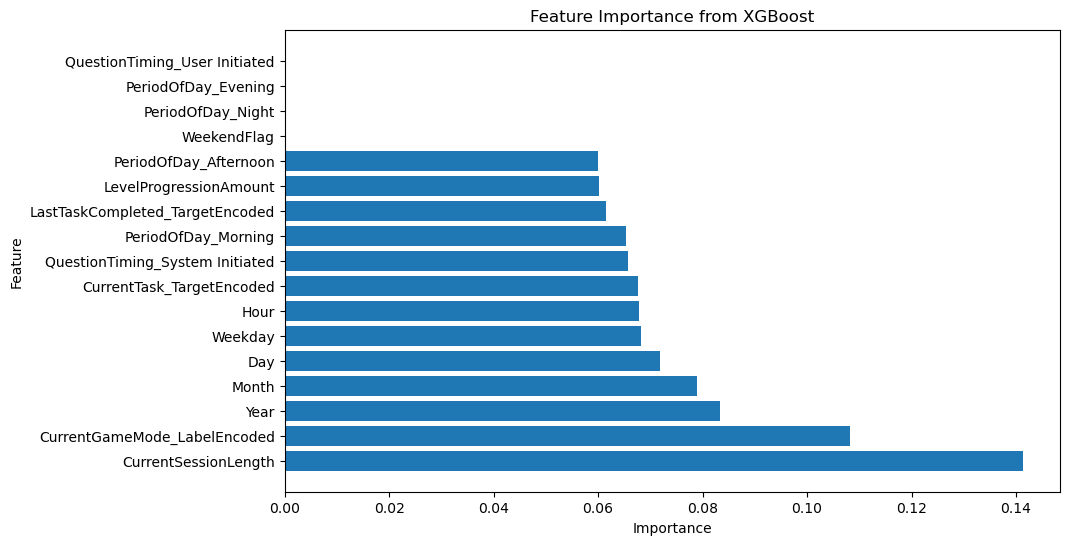

In [65]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

file_path = 'scaled_new_train_data_knn_imputed.csv' 
final_data = pd.read_csv(file_path)

target = 'ResponseValue'
features = final_data.drop(columns=[target])
target_data = final_data[target]

X_train, X_test, y_train, y_test = train_test_split(features, target_data, test_size=0.2, random_state=42)

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)

importance = xgb_model.feature_importances_

feature_importance_xgb = pd.DataFrame({'Feature': features.columns, 'Importance': importance})
feature_importance_xgb = feature_importance_xgb.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_xgb['Feature'], feature_importance_xgb['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from XGBoost')
plt.show()


## Decision Tree

In [66]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Load the data
data_path = 'scaled_new_train_data_knn_imputed.csv'  
data = pd.read_csv(data_path)

# Selecting features and target variable
features = [
    "CurrentSessionLength", "CurrentGameMode_LabelEncoded", "CurrentTask_TargetEncoded",
    "LastTaskCompleted_TargetEncoded", "LevelProgressionAmount", "Month",
    "WeekendFlag", "PeriodOfDay_Night", "QuestionTiming_System Initiated"
]
X = data[features]
y = data['ResponseValue']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating and training the decision tree model
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

# Predicting and evaluating the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Print the evaluation results
print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 83539.08355881037
R-squared Score: -0.8510279407869872
Mean Absolute Error: 224.33987828613695


## Lightgbm

In [60]:
pip install lightgbm


  Obtaining dependency information for lightgbm from https://files.pythonhosted.org/packages/e1/4c/4685ccfae9806f561de716e32549190c1f533dde5bcadaf83bdf23972cf0/lightgbm-4.3.0-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   - -------------------------------------- 0.1/1.3 MB 1.7 MB/s eta 0:00:01
   ------- -------------------------------- 0.2/1.3 MB 3.0 MB/s eta 0:00:01
   --------------- ------------------------ 0.5/1.3 MB 4.1 MB/s eta 0:00:01
   ---------------------- ----------------- 0.7/1.3 MB 4.3 MB/s eta 0:00:01
   ----------------------------- ---------- 1.0/1.3 MB 4.8 MB/s eta 0:00:01
   -------------------------------------- - 1.3/1.3 MB 5.1 MB/s eta 0:00:01
   ---------------------------------------- 1.3/1.3 MB 4.7 MB/s eta 0:00:00


In [67]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import lightgbm as lgb

# Load the data
data_path = 'scaled_new_train_data_knn_imputed.csv'
data = pd.read_csv(data_path)

# Selecting features and target variable
features = [
    "CurrentSessionLength", "CurrentGameMode_LabelEncoded", "CurrentTask_TargetEncoded",
    "LastTaskCompleted_TargetEncoded", "LevelProgressionAmount", "Month",
    "WeekendFlag", "PeriodOfDay_Night", "QuestionTiming_System Initiated"
]
X = data[features]
y = data['ResponseValue']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating and training the LightGBM model
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Setting parameters
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l2', 'mae'],
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# Training the model
num_round = 100
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data], callbacks=[lgb.early_stopping(stopping_rounds=10)])

# Predicting and evaluating the model
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Print the evaluation results
print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")
print(f"Mean Absolute Error: {mae}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's l2: 43908.4	valid_0's l1: 169.414
Mean Squared Error: 43908.39935634973
R-squared Score: 0.027094018973529255
Mean Absolute Error: 169.41412572265565
